This notebook implements the Geostatistics Lesson on Collocated Cokriging. This code is provided for educational purposes and should be reviewed jointly with the lesson <a href="http://www.geostatisticslessons.com/lessons/collocatedcokriging">Collocated Cokriging</a>.

Learning Objectives
- Review simple cokriging.
- Understand the why the Markov Models where developed.
- Explore the differences between Markov model <span>&#8544;</span> and Markov model <span>&#8545;</span>.
- Formulated the Kriging equations using the Markov models.
- Implement the Markov model <span>&#8544;</span> and Markov model <span>&#8545;</span>.
- Understand the Markov model <span>&#8544;</span> and Markov model <span>&#8545;</span> work flow.

In [1]:
print("Package Versions:")
import matplotlib as matplotlib; print("  matplotlib:", matplotlib.__version__)
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd; print("  pandas:", pd.__version__)
import sys; print("  python:", sys.version_info)
import numpy as np; print("  numpy:", np.__version__)
import sklearn as sklearn; print("  sklearn:", sklearn.__version__)
import os
import scipy; print("  scipy:", scipy.__version__)
from scipy import stats
from tqdm import tqdm
from scipy.spatial import distance_matrix
from sklearn.metrics import mean_squared_error

np.set_printoptions(precision=3)

Package Versions:
  matplotlib: 3.4.0
  pandas: 1.2.3
  python: sys.version_info(major=3, minor=8, micro=8, releaselevel='final', serial=0)
  numpy: 1.18.5
  sklearn: 0.24.1
  scipy: 1.6.2


# Import Data

In [2]:
datafl = pd.read_csv("cluster1.out")
datafl_sec = pd.read_csv("ydata.out")
truth = pd.read_csv("true.out")
x = np.asarray(pd.read_csv("x.out")).reshape(len(datafl_sec))
y = np.asarray(pd.read_csv("y.out")).reshape(len(datafl_sec))

In [3]:
print("Primary Data")
datafl.describe()

Primary Data


,X,Y,Primary,Secondary
count,64.000000,64.000000,64.000000,64.000000
mean,50.000000,50.000000,-0.424719,-0.197425
std,28.867513,28.867513,1.032475,0.912744
min,6.250000,6.250000,-2.623800,-2.020500
25%,28.125000,28.125000,-1.015100,-0.767850
50%,50.000000,50.000000,-0.387650,-0.224450
75%,71.875000,71.875000,0.176975,0.254700
max,93.750000,93.750000,2.148700,1.889200


In [4]:
print("Secondary Data")
datafl_sec.describe()

Secondary Data


,X,Y,Secondary
count,10000.000000,10000.000000,10000.000000
mean,50.000000,50.000000,-0.250033
std,28.867513,28.867513,0.936804
min,0.500000,0.500000,-3.272810
25%,25.250000,25.250000,-0.817388
50%,50.000000,50.000000,-0.183005
75%,74.750000,74.750000,0.327833
max,99.500000,99.500000,2.781670


## Maps of the Data

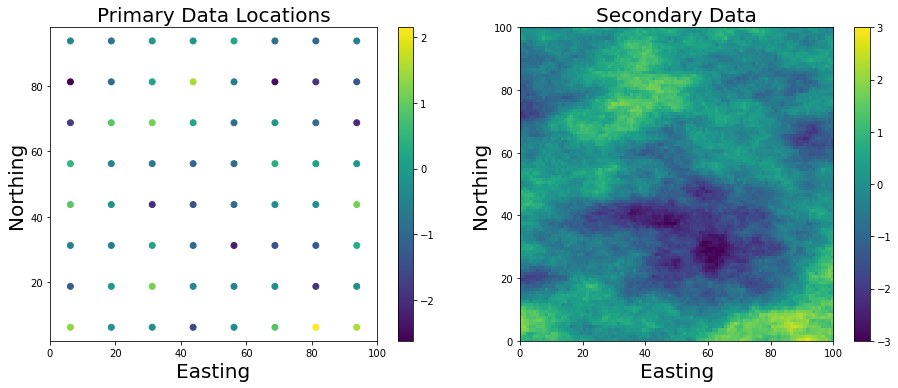

In [5]:
vlim = (-3, 3)
f, ax = plt.subplots(1, 2, figsize=(13, 5.5))
XMIN, XMAX = 0, 100
YMIN, YMAX = 0, 100
SMIN, SMAX = -3, 3
gridd = pd.DataFrame()
gridd["Y"] = y
gridd["X"] = x
gridd["Estimate"] = datafl_sec["Secondary"]
gridded = np.reshape(
    gridd.sort_values(by=["Y", "X"], axis=0, ascending=True)[
        "Estimate"
    ].values,
    [100, 100],
    order="C",
)
img0 = ax[0].scatter(datafl["X"], datafl["Y"], c=datafl["Primary"].values)
ax[0].set_title("Primary Data Locations", size=20)
ax[0].set_xlabel("Easting", size=20)
ax[0].set_ylabel("Northing", size=20)
ax[0].axis("equal")
ax[0].set(xlim=(0, 100), ylim=(0, 100))
img1 = ax[1].imshow(
    gridded,
    origin="lower",
    extent=[XMIN, XMAX, YMIN, YMAX],
    aspect="equal",
    interpolation="none",
    vmin=SMIN,
    vmax=SMAX,
    cmap="viridis",
)
ax[1].set_xlabel("Easting", size=20)
ax[1].set_ylabel("Northing", size=20)
ax[1].set_title("Secondary Data", size=20)
f.colorbar(img0, ax=ax[0])
f.colorbar(img1, ax=ax[1])
plt.tight_layout()
plt.savefig("truth.png", bbox_inches="tight", dpi=300)

## Check the Distribution and Correlation of the Data

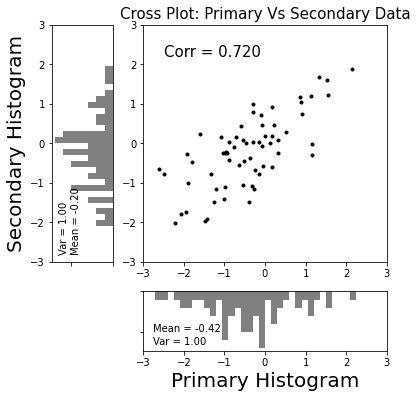

In [6]:
# Set up the axes with gridspec
corr = np.corrcoef(datafl["Primary"], datafl["Secondary"])[0, 1]
vlim = (-3, 3)
fig = plt.figure(figsize=(6, 6))
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.5)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

# scatter points on the main axes
main_ax.plot(datafl["Primary"], datafl["Secondary"], "ok", markersize=3)
main_ax.set_xlim(vlim)
main_ax.set_ylim(vlim)
main_ax.set_title("Cross Plot: Primary Vs Secondary Data", size=15)
main_ax.text(-2.5, 2.2,
    "Corr = {0:.3f}".format(
        np.corrcoef(datafl["Primary"], datafl["Secondary"])[0, 1]
    ),
    size=15
)

# histogram on the attached axes
x_hist.hist(
    datafl["Primary"],
    40,
    histtype="stepfilled",
    label="Primary",
    orientation="vertical",
    color="gray",
    range=vlim,
)
x_hist.set_xlabel("Primary Histogram", size=20)
x_hist.invert_yaxis()
x_hist.text(-2.75, 5, "Mean = {0:.2f}".format(np.average(datafl["Primary"])),
            size=10)
x_hist.text(-2.75, 6.5, "Var = {0:.2f}".format(1.00), size=10)


y_hist.hist(
    datafl["Secondary"],
    40,
    histtype="stepfilled",
    orientation="horizontal",
    color="gray",
    range=vlim,
)
y_hist.set_ylabel("Secondary Histogram", size=20)
y_hist.invert_xaxis()
y_hist.text(5, -2.75, "Mean = {0:.2f}".format(np.average(datafl["Secondary"])),
            rotation=90, size=10)
y_hist.text(6.5, -2.75, "Var = {0:.2f}".format(1.00), rotation=90, size=10)
plt.savefig("cross_plot.png", bbox_inches="tight", dpi=300)

# Correlograms 

## Initialize Correlogram Types 

In [7]:
def covar(t, d, r,b=1):
    h = d / r
    if t == 1:  # Spherical
        c = b*(1 - h * (1.5 - 0.5 * np.square(h)))
        c[h > 1] = 0
    elif t == 2:  # Exponential
        c = np.exp(-3 * h)
    elif t == 3:  # Gaussian
        c = b*(np.exp(-3 * np.square(h)))
    return c

## Fit Experimental Correlogram Points 

Experimental variogram points were pre-calculated.

In [8]:
varcalcfl_1 = pd.read_csv("varcalc_Cluster.out")
varcalcfl_2 = pd.read_csv("varcalc_YDATA.out")
varcalcfl_3 = pd.read_csv("varcalc_Cross.out")

In [9]:
varcalcfl_1

,Variogram Index,Lag Distance,Number of Pairs,Variogram Value,Variogram Number,Calculation Azimuth,Calculation Dip,Variogram Type,Variogram Tail Index,Variogram Head Index
0,1.0,12.50000,56.0,0.55392,1.0,90.0,0.0,1.0,1.0,1.0
1,1.0,18.26923,104.0,0.81400,1.0,90.0,0.0,1.0,1.0,1.0
2,1.0,23.61111,144.0,0.97687,1.0,90.0,0.0,1.0,1.0,1.0
3,1.0,37.19470,190.0,1.20535,1.0,90.0,0.0,1.0,1.0,1.0
4,1.0,46.18544,222.0,1.18777,1.0,90.0,0.0,1.0,1.0,1.0
5,1.0,59.64312,206.0,1.04701,1.0,90.0,0.0,1.0,1.0,1.0
6,1.0,70.37440,178.0,0.95990,1.0,90.0,0.0,1.0,1.0,1.0
7,1.0,82.21213,112.0,1.08734,1.0,90.0,0.0,1.0,1.0,1.0
8,1.0,90.48693,44.0,1.20315,1.0,90.0,0.0,1.0,1.0,1.0
9,1.0,112.50000,0.0,-999.00000,1.0,90.0,0.0,1.0,1.0,1.0


<ipython-input-10-4370bdc5db55>:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes[j, i].plot(
<ipython-input-10-4370bdc5db55>:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes[j, i].plot(
<ipython-input-10-4370bdc5db55>:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes[j, i].plot(
<ipython-input-10-4370bdc5db55>:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes[j, i].plot(
<ipython-input-10-4370bdc5db55>:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). Th

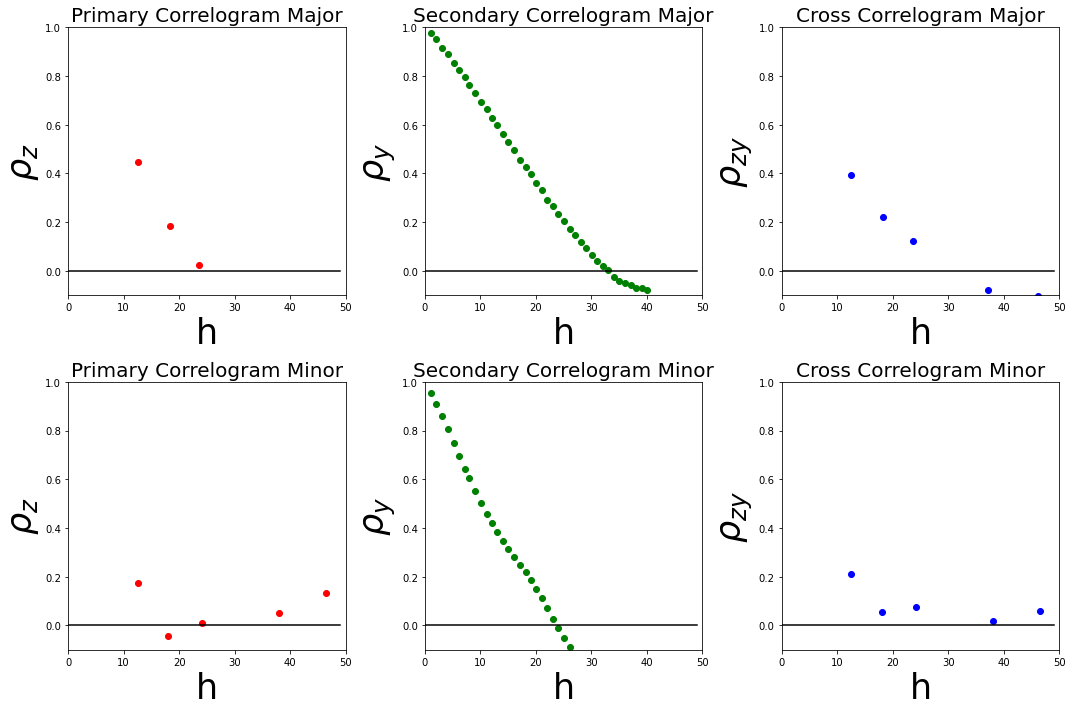

In [10]:
ones = np.zeros(shape=(50))
Cross_ones = np.zeros(shape=(50))
H = np.zeros(shape=(50))
Corr_labels = [
    "Primary Correlogram",
    "Secondary Correlogram",
    "Cross Correlogram",
]
Directions = ["Major", "Minor"]
colors = ["Red", "Green", "Blue"]
labels_2 = ["$\u03C1_{z}$", "$\u03C1_{y}$", "$\u03C1_{zy}$"]
Sill_vals = [1, 1, corr]
for h in range(1, 50):
    H[h] = h
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i in range(0, 3):
    var = locals()["varcalcfl_{}".format(i + 1)]
    for j in range(0, 2):
        axes[j, i].plot(
            var["Lag Distance"][var["Variogram Index"] == (j + 1)],
            Sill_vals[i]
            - var["Variogram Value"][var["Variogram Index"] == (j + 1)],
            "ro",
            color=colors[i],
        )
        axes[j, i].set_ylabel(labels_2[i], size=35)
        axes[j, i].plot(H, ones, color="Black")
        axes[j, i].set_xlabel("h", size=35)
        axes[j, i].set_title(Corr_labels[i] + " " + Directions[j], size=20)
plt.setp(axes, xlim=(0, 50), ylim=(-0.1, 1))
plt.tight_layout()
plt.savefig('true_variograms.png', bbox_inches="tight", dpi=300)

## Calculate Rotation Matrix

Using a major direction of 90 degrees east of north, this is farily obvious from the primary and secondary data. See http://www.geostatisticslessons.com/lessons/anglespecification

In [11]:
def Rot_Mat(Azimuth, a_max, a_min):
    theta = (Azimuth / 180.0) * np.pi
    Rot_Mat = np.dot(
        np.array([[1 / a_max, 0], [0, 1 / a_min]]),
        np.array(
            [
                [np.cos(theta), np.sin(theta)],
                [-np.sin(theta), np.cos(theta)],
            ]
        ),
    )
    return Rot_Mat

## Primary Correlogram

In [458]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_Z(h1, h2, k,a_max,a_min):
    C = []
    nstruct = 1
    vtype = [3] 
    #a_max = [24]
    #a_min = [16]
    Azimuth = 90
    cc = [1]
    c = 0
    for i in range(nstruct):
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                ).sum(axis=1)
            )
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1) * cc[i]
    return c

## Secondary Correlogram

In [13]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_Y(h1, h2, k,a_max,a_min):
    C = []
    nstruct = 2
    vtype = [1, 3]
    #a_max = [42, 43]
    #a_min = [28.5, 30]
    Azimuth = 90
    cc = [0.9, 0.1]
    c = 0
    for i in range(nstruct):
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                )
            ).sum(axis=1)
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1) * cc[i]
    return c

## Scaling Correlogram

In [14]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_r(h1, h2, k):
    C = []
    nstruct = 1
    vtype = [3]
    a_max = [18]
    a_min = [13]
    Azimuth = 90
    cc = [1]
    c = 0
    for i in range(nstruct):
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                ).sum(axis=1)
            )
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1) * cc[i]
    return c

## C_Z Correlogram MM2

In [15]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# Corr = correlation between primary and secondary data
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_Z_MM2(h1, h2, k, corr):
    return (C_Y(h1, h2, k) * corr ** 2) + (
        (1 - corr ** 2) * C_r(h1, h2, k)
    )

## Plots Correlogram Models

In [16]:
# Define some matrices for storing variogram values
LENGTH = 50
cy = np.zeros(shape=(51))
cz_True = np.zeros(shape=(51))
cr = np.zeros(shape=(51))
cz = np.zeros(shape=(51))
czy = np.zeros(shape=(51))
H = np.zeros(shape=(51))
ones = np.zeros(shape=(51))
cy_LMC = np.zeros(shape=(51))
cz_LMC = np.zeros(shape=(51))
czy_LMC = np.zeros(shape=(51))
# Define some plotting labels
labels_1 = [
    "$\hat{\u03C1_{z}}$",
    "$\hat{\u03C1_{y}}$",
    "$\hat{\u03C1_{zy}}$",
]
labels_MM = [
    "$\u03C1_{z_{Model}}$",
    "$\u03C1_{y_{Model}}$",
    "$\u03C1_{z_{MMII}}$",
]
labels_lmc = [
    "$\u03C1_{z_{LMC}}$",
    "$\u03C1_{y_{LMC}}$",
    "$\u03C1_{zy_{LMC}}$",
]
colors_lmc = ["Orange", "Yellow", "Grey"]

## Plot Primary Correlogram Model 

20.0 10.0
21.0 11.0
22.0 12.0
23.0 13.0
24.0 14.0
25.0 15.0
26.0 16.0
27.0 17.0
28.0 18.0
29.0 19.0
30.0 20.0
20.0 10.0
21.0 11.0
22.0 12.0
23.0 13.0
24.0 14.0
25.0 15.0
26.0 16.0
27.0 17.0
28.0 18.0
29.0 19.0
30.0 20.0


<ipython-input-17-39101a20d1b0>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes[k].plot(
<ipython-input-17-39101a20d1b0>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes[k].plot(
<ipython-input-17-39101a20d1b0>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes[k].plot(
<ipython-input-17-39101a20d1b0>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes[k].plot(
<ipython-input-17-39101a20d1b0>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword ar

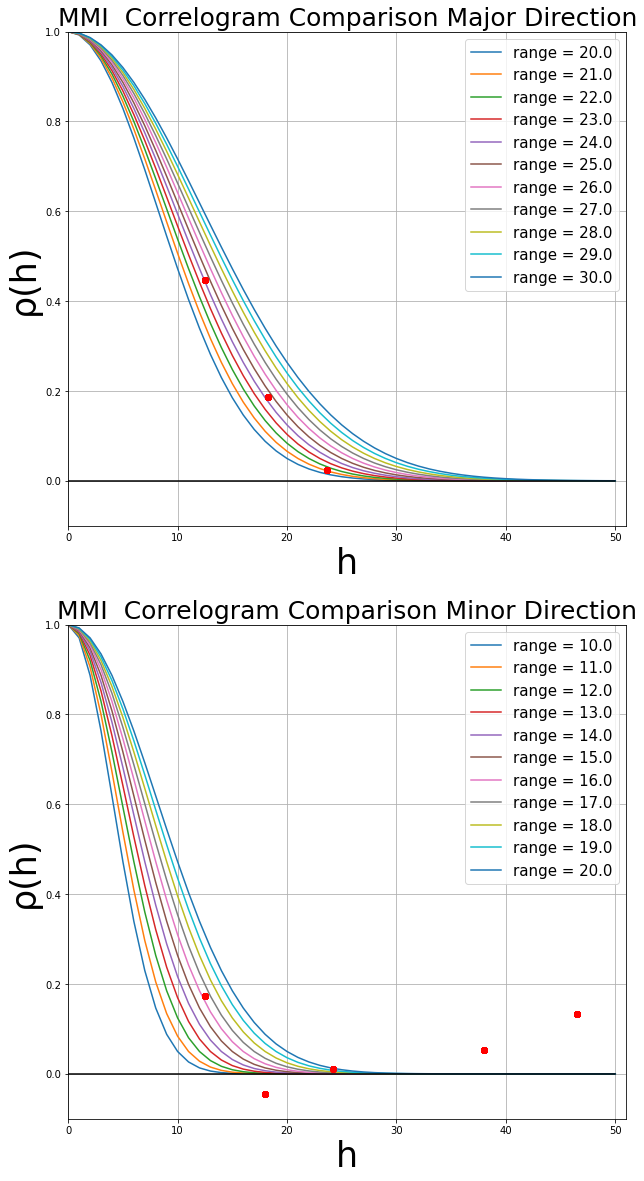

In [17]:
varg_type = 2  # See Correlogram Functions

a_min_mesh = np.linspace(10,20,11)
a_max_mesh = np.linspace(20,30,11)
k = 0
fig, axes = plt.subplots(2, 1, figsize=(10, 20))
for Dir in Directions:
    
    for a_max,a_min in zip(a_max_mesh,a_min_mesh) :
        print(a_max,a_min)
        
        for h in range(0, LENGTH + 1):
            cz_True[h] = C_Z(np.matrix(h), np.matrix(h), varg_type,[a_max],[a_min])
            H[h] = h
        MM_vargs = [ cz_True,None,None ]
        
        for i in range(0, 1):
            if Dir == "Major" : 
                LABEL =  "range = {}".format(a_max)
            else :
                LABEL =  "range = {}".format(a_min)
            axes[k].plot(H, MM_vargs[i], label=LABEL)
            if (i + 1) < 3:
               
                    
                var = locals()["varcalcfl_{}".format(i + 1)]
                axes[k].plot(
                    var["Lag Distance"][
                        var["Variogram Index"] == (varg_type - 1)
                    ],
                    Sill_vals[i]
                    - var["Variogram Value"][
                        var["Variogram Index"] == (varg_type - 1)
                    ],
                    "ro",
                    color=colors[i]
                )

    axes[k].plot(H, ones, color="Black")
    axes[k].grid()
    axes[k].set_xlim(0, LENGTH + 1)
    axes[k].set_ylim(-0.1, 1)
    axes[k].set_ylabel("\u03C1(h)", size=35)
    axes[k].set_xlabel("h", size=35)
    axes[k].set_title(
        "MMI  Correlogram Comparison {} Direction".format(Dir),
        size=25,
    )
    axes[k].legend(loc="best", prop={"size": 15})
    #plt.savefig("MM1_MM2_var_{}".format(Dir), bbox_inches="tight", dpi=300)
    varg_type = varg_type + 1
    k +=1

## Plot Secondary Correlogram Model 

35.0 25.0
37.0 27.0
39.0 29.0
41.0 31.0
43.0 33.0
45.0 35.0
35.0 25.0
37.0 27.0
39.0 29.0
41.0 31.0
43.0 33.0
45.0 35.0


<ipython-input-18-4bfb6cd837d7>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes[k].plot(
<ipython-input-18-4bfb6cd837d7>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes[k].plot(
<ipython-input-18-4bfb6cd837d7>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes[k].plot(
<ipython-input-18-4bfb6cd837d7>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes[k].plot(
<ipython-input-18-4bfb6cd837d7>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword ar

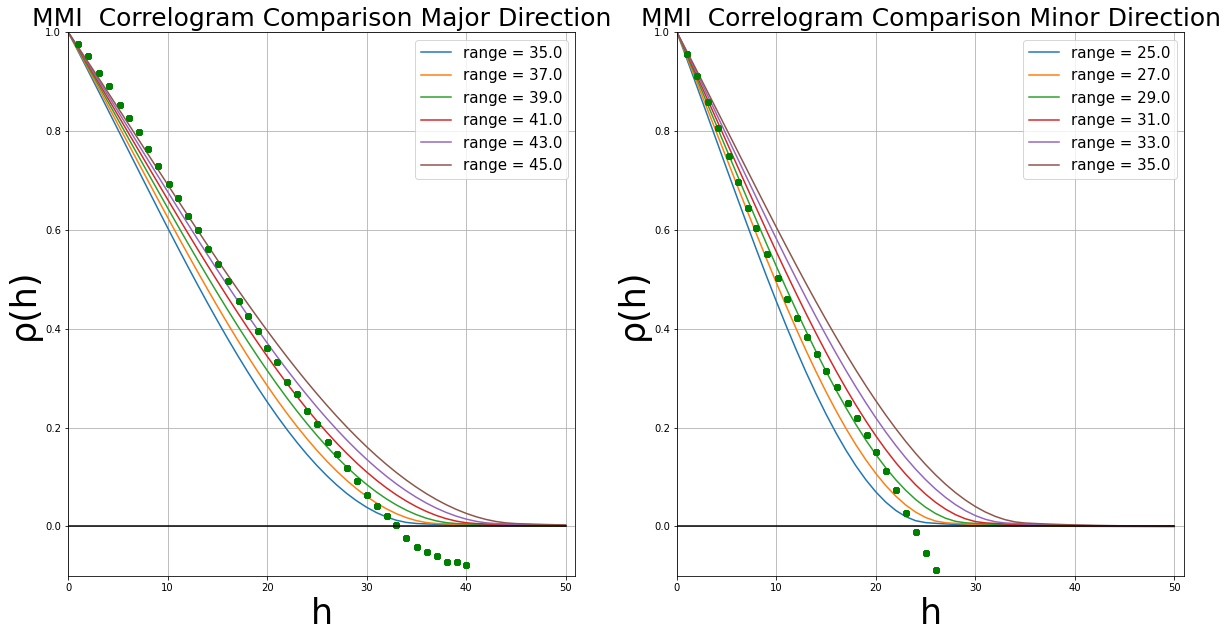

In [18]:
varg_type = 2  # See Correlogram Functions

a_min_mesh = np.linspace(25,35,6)
a_max_mesh = np.linspace(35,45,6)
k = 0
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
for Dir in Directions:
    
    for a_max,a_min in zip(a_max_mesh,a_min_mesh) :
        print(a_max,a_min)
        
        for h in range(0, LENGTH + 1):
            cy[h] = C_Y(np.matrix(h), np.matrix(h), varg_type,[a_max,a_max+1],[a_min,a_min+2])
            H[h] = h
        MM_vargs = [ None,cy,None ]
        
        for i in range(1, 2):
            if Dir == "Major" : 
                LABEL =  "range = {}".format(a_max)
            else :
                LABEL =  "range = {}".format(a_min)
            axes[k].plot(H, MM_vargs[i], label=LABEL)
            if (i + 1) < 3:
               
                    
                var = locals()["varcalcfl_{}".format(i + 1)]
                axes[k].plot(
                    var["Lag Distance"][
                        var["Variogram Index"] == (varg_type - 1)
                    ],
                    Sill_vals[i]
                    - var["Variogram Value"][
                        var["Variogram Index"] == (varg_type - 1)
                    ],
                    "ro",
                    color=colors[i]
                )

    axes[k].plot(H, ones, color="Black")
    axes[k].grid()
    axes[k].set_xlim(0, LENGTH + 1)
    axes[k].set_ylim(-0.1, 1)
    axes[k].set_ylabel("\u03C1(h)", size=35)
    axes[k].set_xlabel("h", size=35)
    axes[k].set_title(
        "MMI  Correlogram Comparison {} Direction".format(Dir),
        size=25,
    )
    axes[k].legend(loc="best", prop={"size": 15})
    #plt.savefig("MM1_MM2_var_{}".format(Dir), bbox_inches="tight", dpi=300)
    varg_type = varg_type + 1
    k +=1

## Variateur des parametres des correlogrammes

### Secondary 

In [369]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_Y_alternate(h1, h2, k,a_max,a_min,cc = [0.6,0.4],vtype = [1,3],nstruct = 2):
    C = []
    #nstruct = 2
    #vtype = [1,3]
    #a_max = [42, 43]
    #a_min = [28.5, 30]
    Azimuth = 90
    #cc = 0.6,0.4
    c = 0.0
    for i in range(nstruct):
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                )
            ).sum(axis=1)
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1) * cc[i]

    return c,cc,vtype

35.0 25.0
37.0 27.0
39.0 29.0
41.0 31.0
43.0 33.0
45.0 35.0
35.0 25.0
37.0 27.0
39.0 29.0
41.0 31.0
43.0 33.0
45.0 35.0


<ipython-input-20-b98974fdbb00>:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes[k].plot(
<ipython-input-20-b98974fdbb00>:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes[k].plot(
<ipython-input-20-b98974fdbb00>:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes[k].plot(
<ipython-input-20-b98974fdbb00>:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes[k].plot(
<ipython-input-20-b98974fdbb00>:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword ar

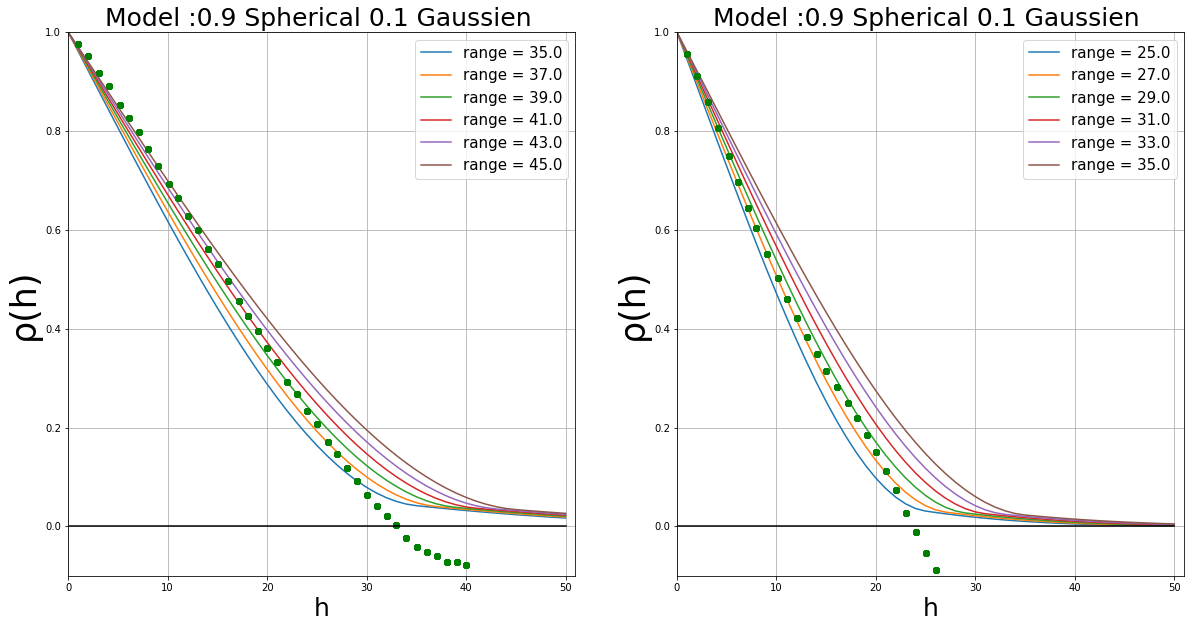

In [20]:
varg_type = 2  # See Correlogram Functions
Model = "Model7"


a_min_mesh = np.linspace(25,35,6)
a_max_mesh = np.linspace(35,45,6)
k = 0

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

MODEL = ["Spherical","Exponentiel","Gaussien"]
for Dir in Directions:
    
    for a_max,a_min in zip(a_max_mesh,a_min_mesh) :
        print(a_max,a_min)
        
        for h in range(0, LENGTH + 1):
            cy[h],cc,vtype = C_Y_alternate(np.matrix(h), np.matrix(h), varg_type,[a_max,a_max+30],[a_min,a_min+15])
            H[h] = h
        MM_vargs = [ None,cy,None ]
        
        for i in range(1, 2):
            if Dir == "Major" : 
                LABEL =  "range = {}".format(a_max)
            else :
                LABEL =  "range = {}".format(a_min)
            axes[k].plot(H, MM_vargs[i], label=LABEL)
            if (i + 1) < 3:
               
                    
                var = locals()["varcalcfl_{}".format(i + 1)]
                axes[k].plot(
                    var["Lag Distance"][
                        var["Variogram Index"] == (varg_type - 1)
                    ],
                    Sill_vals[i]
                    - var["Variogram Value"][
                        var["Variogram Index"] == (varg_type - 1)
                    ],
                    "ro",
                    color=colors[i]
                )
    
    TITLE = "Model :"
    for i in range(len(cc)) :
        TITLE += f"{cc[i]} {MODEL[vtype[i]-1]} "
        
    axes[k].plot(H, ones, color="Black")
    axes[k].grid()
    axes[k].set_xlim(0, LENGTH + 1)
    axes[k].set_ylim(-0.1, 1)
    axes[k].set_ylabel("\u03C1(h)", size=35)
    axes[k].set_xlabel("h", size=25)
    axes[k].set_title(
        TITLE,
        size=25,
    )
    axes[k].legend(loc="best", prop={"size": 15})
    #plt.savefig("MM1_MM2_var_{}".format(Dir), bbox_inches="tight", dpi=300)
    varg_type = varg_type + 1
    k +=1
    
    
    fileout =  "C:/Users/Alexandre/Desktop/Cours/Stage/\collocatedcokriging/\Correlogram_test/"+Model+".png"
    #plt.savefig(fileout, bbox_inches="tight")
    #axes[k].set_title(
        #"MMI  Correlogram Comparison {} Direction".format(Dir),
       # size=25)

## Une seule courbe

[42, 43] [28.5, 30]
[42, 43] [28.5, 30]


<ipython-input-21-bfdc95cabd40>:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes[k].plot(
<ipython-input-21-bfdc95cabd40>:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes[k].plot(


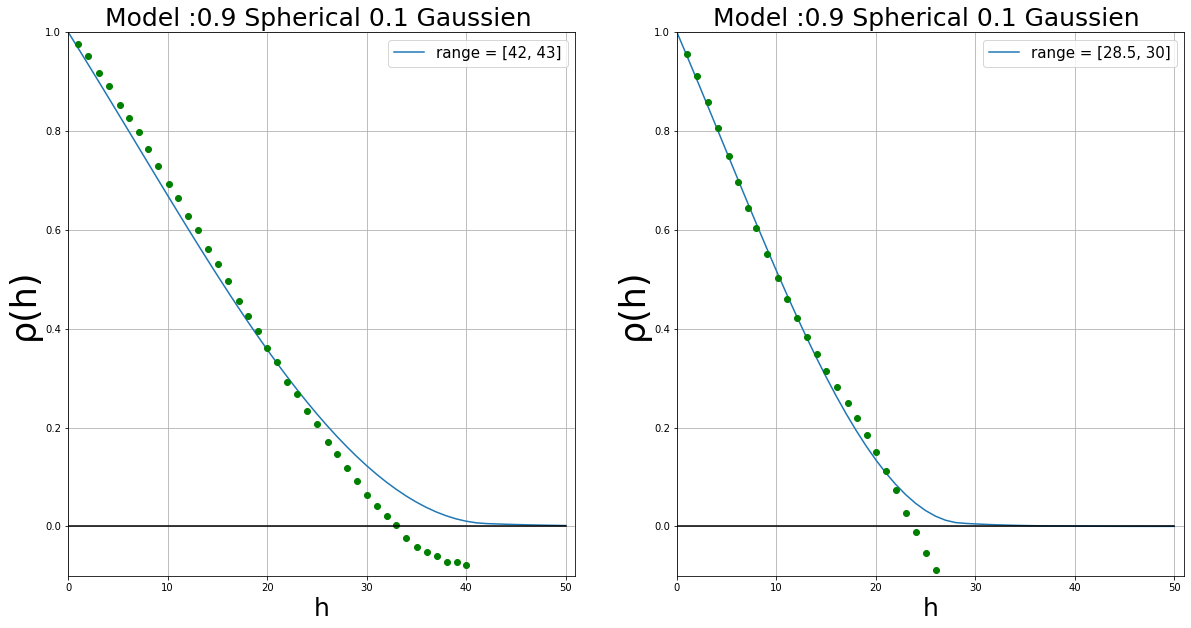

In [21]:
varg_type = 2  # See Correlogram Functions
Model = "Model8"


a_min_mesh = np.linspace(25,35,6)
a_max_mesh = np.linspace(35,45,6)
a_max = [42, 43]
a_min = [28.5, 30]
k = 0
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

MODEL = ["Spherical","Exponentiel","Gaussien"]
for Dir in Directions:
    
    print(a_max,a_min)

    for h in range(0, LENGTH + 1):
        cy[h],cc,vtype = C_Y_alternate(np.matrix(h), np.matrix(h), varg_type,a_max,a_min)
        H[h] = h
    MM_vargs = [ None,cy,None ]

    for i in range(1, 2):
        if Dir == "Major" : 
            LABEL =  "range = {}".format(a_max)
        else :
            LABEL =  "range = {}".format(a_min)
        axes[k].plot(H, MM_vargs[i], label=LABEL)
        if (i + 1) < 3:


            var = locals()["varcalcfl_{}".format(i + 1)]
            axes[k].plot(
                var["Lag Distance"][
                    var["Variogram Index"] == (varg_type - 1)
                ],
                Sill_vals[i]
                - var["Variogram Value"][
                    var["Variogram Index"] == (varg_type - 1)
                ],
                "ro",
                color=colors[i]
                )
    
    TITLE = "Model :"
    for i in range(len(cc)) :
        TITLE += f"{cc[i]} {MODEL[vtype[i]-1]} "
        
    axes[k].plot(H, ones, color="Black")
    axes[k].grid()
    axes[k].set_xlim(0, LENGTH + 1)
    axes[k].set_ylim(-0.1, 1)
    axes[k].set_ylabel("\u03C1(h)", size=35)
    axes[k].set_xlabel("h", size=25)
    axes[k].set_title(
        TITLE,
        size=25,
    )
    axes[k].legend(loc="best", prop={"size": 15})
    #plt.savefig("MM1_MM2_var_{}".format(Dir), bbox_inches="tight", dpi=300)
    varg_type = varg_type + 1
    k +=1
    
    
    fileout =  "C:/Users/Alexandre/Desktop/Cours/Stage/\collocatedcokriging/\Correlogram_test/"+Model+".png"
    #plt.savefig(fileout, bbox_inches="tight")
    #axes[k].set_title(
        #"MMI  Correlogram Comparison {} Direction".format(Dir),
       # size=25)

# Optimisation de la variable Y

gamma=b*spherical(a_min,a_max)

Tu optimises en calculant un RMSE entre ton modele généré et tes points 

Prend un nelder-mead ou un Cobyla ou BFGS 

In [22]:
from scipy.optimize import minimize
print(scipy.optimize.minimize.__doc__)


Minimization of scalar function of one or more variables.

    Parameters
    ----------
    fun : callable
        The objective function to be minimized.

            ``fun(x, *args) -> float``

        where ``x`` is an 1-D array with shape (n,) and ``args``
        is a tuple of the fixed parameters needed to completely
        specify the function.
    x0 : ndarray, shape (n,)
        Initial guess. Array of real elements of size (n,),
        where 'n' is the number of independent variables.
    args : tuple, optional
        Extra arguments passed to the objective function and its
        derivatives (`fun`, `jac` and `hess` functions).
    method : str or callable, optional
        Type of solver.  Should be one of

            - 'Nelder-Mead' :ref:`(see here) <optimize.minimize-neldermead>`
            - 'Powell'      :ref:`(see here) <optimize.minimize-powell>`
            - 'CG'          :ref:`(see here) <optimize.minimize-cg>`
            - 'BFGS'        :ref:`(see here) <o

# Optimize

In [25]:
def covar(t, d, r,b=1):
    h = d / r
    if t == 1:  # Spherical
        c = b*(1 - h * (1.5 - 0.5 * np.square(h)))
        c[h > 1] = 0
    elif t == 2:  # Exponential
        c = np.exp(-3 * h)
    elif t == 3:  # Gaussian
        c = b*(np.exp(-3 * np.square(h)))
    return c

### Single Model  (Z)

In [466]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_Z_alternate(h1, h2, k,a_max,a_min,vtype = [3],cc = [1],nstruct = 1):
    C = []
    #nstruct = 1
    #vtype = [3] 
    #a_max = [24]
    #a_min = [16]
    Azimuth = 90
    #cc = [1]
    c = 0
    for i in range(nstruct):
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                ).sum(axis=1)
            )
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1) * cc[i]
    return c

In [288]:
def optimize_RMSE_single_model(x, args):
    """
    args : args[0] correspond au DataFrame ; args[1] correspond à la Sill_value (= 1)
    gamma= b*spherical(a_min,a_max)
    """
    
    var = args[0][args[0]["Variogram Value"] != -999] # drop les valeurs -999 
    Sill_value = args[1]
    RMSE = [] # Liste des RMSE
    Direction = ["Major", "Minor"] #deux directions à additionner
    
    for i,Dir in enumerate(Direction) :
        c = [] # liste des covario
        a_range = x[i] # range
        b = x[2]       # effet pépite
        #print(a_range , b)
        
        variogram_lag = var["Lag Distance"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        variogram_value = Sill_value - var["Variogram Value"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        lag_value = variogram_lag / a_range # valeurs des lags / range
        
        for h in lag_value:

            MODEL = b*(np.exp(-3 * np.square(h))) # Gaussien 
            c.append(MODEL)
            
        RMSE.append(np.sqrt(mean_squared_error(variogram_value,c)))
        #print("sum(RMSE) :", sum(RMSE), "\n")
    return sum(RMSE)

In [406]:
# Allocation des constantes 
a_max0, a_min0, b0 = 42, 28.5, 1
var, Sill_value = varcalcfl_1, 1
x0 = np.array([a_max0, a_min0, b0])
args = np.array([var,Sill_value])
# Boundaries 
Bounds = [[1,1000], [1,1000], [0,1]]
# Minimize
single_model = minimize(optimize_RMSE_single_model,x0,args = args,
                            method='TNC', jac = '3-point',
                            bounds = Bounds,tol = 1e-9)

a_max_z, a_min_z, b_z = single_model.x
print(single_model)

     fun: 0.26027744109178164
     jac: array([-3.522e-08, -3.481e-08, -3.829e-03])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 266
     nit: 8
  status: 1
 success: True
       x: array([23.908, 15.888,  1.   ])


In [412]:
#Réduit la précision des variables 
name_var = ["a_max_z", "a_min_z", "b_z"]
number_var = [a_max_z, a_min_z, b_z]

for name,number in zip(name_var,number_var) :
    if name == "b_z" :
        locals()[f"{name}"] = number
    else :
        locals()[f"{name}"] = float("{:.0f}".format(number))
    print(name,":",locals()[f"{name}"])

a_max_z : 24.0
a_min_z : 16.0
b_z : 1.0


24.0 16.0
24.0 16.0


<ipython-input-470-0eb02c4d7a73>:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes[k].plot(
<ipython-input-470-0eb02c4d7a73>:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes[k].plot(


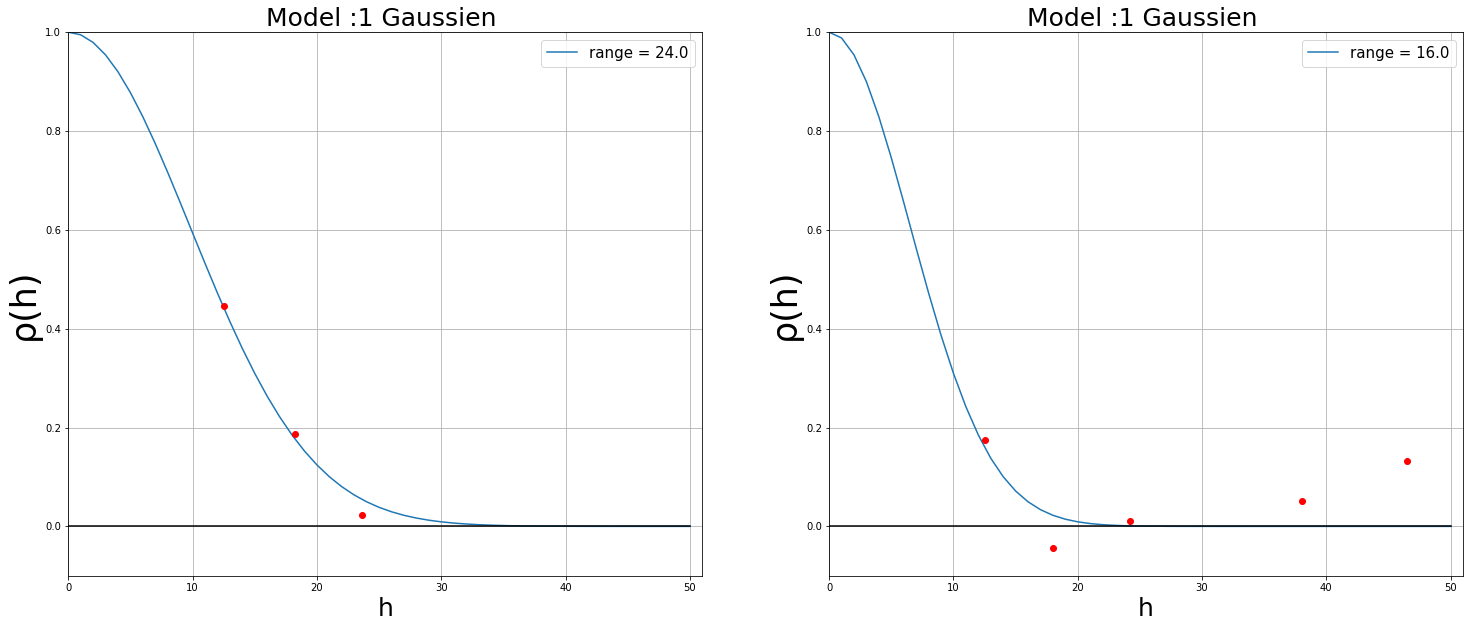

In [470]:
varg_type = 2  # See Correlogram Functions
Model = ""


a_min_mesh = np.linspace(25,35,6)
a_max_mesh = np.linspace(35,45,6)
a_max = a_max_z
a_min = a_min_z
cc = [1]
vtype = [3]
k = 0
fig, axes = plt.subplots(1, 2, figsize=(25, 10))

MODEL = ["Spherical","Exponentiel","Gaussien"]
for Dir in Directions:
    
    print(a_max,a_min)

    for h in range(0, LENGTH + 1):
        cz_True[h] = C_Z_alternate(np.matrix(h), np.matrix(h),varg_type,[a_max],[a_min],vtype,cc)
        H[h] = h
        MM_vargs = [ cz_True,None,None ]

    for i in [0]:
        if Dir == "Major" : 
            LABEL =  "range = {}".format(a_max)
        else :
            LABEL =  "range = {}".format(a_min)
        axes[k].plot(H, MM_vargs[i], label=LABEL)
        if (i + 1) < 3:


            var = locals()["varcalcfl_{}".format(i + 1)]
            axes[k].plot(
                var["Lag Distance"][
                    var["Variogram Index"] == (varg_type - 1)
                ],
                Sill_vals[i]
                - var["Variogram Value"][
                    var["Variogram Index"] == (varg_type - 1)
                ],
                "ro",
                color=colors[i]
                )
    
    TITLE = "Model :"
    for i in range(len(cc)) :
        TITLE += f"{cc[i]} {MODEL[vtype[i]-1]} "
        
    axes[k].plot(H, ones, color="Black")
    axes[k].grid()
    axes[k].set_xlim(0, LENGTH + 1)
    axes[k].set_ylim(-0.1, 1)
    axes[k].set_ylabel("\u03C1(h)", size=35)
    axes[k].set_xlabel("h", size=25)
    axes[k].set_title(
        TITLE,
        size=25,
    )
    axes[k].legend(loc="best", prop={"size": 15})
    #plt.savefig("MM1_MM2_var_{}".format(Dir), bbox_inches="tight", dpi=300)
    varg_type = varg_type + 1
    k +=1
    
    
    fileout =  "C:/Users/Alexandre/Desktop/Cours/Stage/\collocatedcokriging/\Correlogram_test/"+Model+".png"
    #plt.savefig(fileout, bbox_inches="tight")
    #axes[k].set_title(
        #"MMI  Correlogram Comparison {} Direction".format(Dir),
       # size=25)

### Dual Model 

In [370]:
def optimize_RMSE_dual_model(x, args):
    """
    args : args[0] correspond au DataFrame ; args[1] correspond à la Sill_value (= 1)
    gamma= b*spherical(a_min,a_max)+ c*gaussian(a_min_g,a_max_g)
    """
    
    var = args[0][args[0]["Variogram Value"] != -999] # drop les valeurs -999 
    Sill_value = args[1]
    RMSE = [] # Liste des RMSE
    Direction = ["Major", "Minor"] #deux directions à additionner
    hh = []
    for i,Dir in enumerate(Direction) :
        cov = [] # liste des covario
        a_gauss = x[i]        # range du model Gaussian
        a_spher = x[2+i]      # range du model Spherical
        b = x[4]              # effet pépite n1
        c = np.absolute(1-b)  # effet pépite n2
        
        variogram_lag = var["Lag Distance"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        variogram_value = Sill_value - var["Variogram Value"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        lag_value_gauss = variogram_lag / a_gauss # valeurs des lags / range
        lag_value_spher = variogram_lag / a_spher # valeurs des lags / range
        
        #print("a_gauss :",a_gauss, "a_spher :",a_spher)
        for h_gauss,h_spher in zip(lag_value_gauss,lag_value_spher):
            GAUSSIAN = (np.exp(-3 * np.square(h_gauss)))
            
            # Condition ; SPHERICAL[h > 1] = 0
            if h_gauss > 1.0 :
                SPHERICAL = 0
            else :
                SPHERICAL = 1 - h_spher * (1.5 - 0.5 * np.square(h_spher))
                
            MODEL = b * GAUSSIAN + c * SPHERICAL
            cov.append(MODEL)
            
        RMSE.append(np.sqrt(mean_squared_error(variogram_value,cov)))
    #print("sum(RMSE) :", sum(RMSE), "\n")
    return sum(RMSE)

In [476]:
# Allocation des constantes 
# b0 : effet pepite du model gaussien
#a_max_gauss0, a_min_gauss0,a_max_spher0, a_min_spher0, b0 = 42, 28.5, 43, 30, 1
a_max_gauss0, a_min_gauss0,a_max_spher0, a_min_spher0, b0 = 25, 10, 40, 25, 0.5
var, Sill_value = varcalcfl_2, 1
x0   = np.array([a_max_gauss0, a_min_gauss0,a_max_spher0, a_min_spher0, b0])
args = np.array([var,Sill_value])

# Boundaries 
Bounds = [[1,100], [1,100], [1,100], [1,100], [0,1]] # a_max_gauss0, a_min_gauss0,a_max_spher0, a_min_spher0, b0, c0
# Minimize
options = {"xtol" : 1e-5,
           "gtol" : 1e-5}

dual_model = minimize(optimize_RMSE_dual_model, x0, args = args,
                            method='TNC', jac = '3-point',
                            bounds = Bounds,
                      tol = 1e-9, options = options)

a_max_gauss, a_min_gauss, a_max_spher, a_min_spher, b= dual_model.x
c = 1-b
print(dual_model, c)

     fun: 0.17742258155002363
     jac: array([-7.650e-04, -2.695e+00, -6.014e-04, -8.344e-05,  1.651e-02])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 935
     nit: 5
  status: 1
 success: True
       x: array([32.262, 21.002, 42.687, 32.166,  0.456]) 0.5443111745784971


In [472]:
#Réduit la précision des variables 
name_var = ["a_max_gauss", "a_min_gauss", "a_max_spher", "a_min_spher","b","c"]
number_var = [a_max_gauss, a_min_gauss, a_max_spher, a_min_spher,b,c]

for name,number in zip(name_var,number_var) :
    if name == "b" or name == "c" :
        locals()[f"{name}"] = float("{:.1f}".format(number))
    else :
        locals()[f"{name}"] = float("{:.0f}".format(number))
    print(name,":",locals()[f"{name}"])

a_max_gauss : 33.0
a_min_gauss : 22.0
a_max_spher : 43.0
a_min_spher : 30.0
b : 0.3
c : 0.7


In [396]:
a = ["aaa","bbb"]
aa = [13.5,22.1]
for test,number in zip(a,aa) :
    locals()[f"{test}"] = float("{:.0f}".format(number))

[33.0, 43.0] [22.0, 30.0]
[33.0, 43.0] [22.0, 30.0]


<ipython-input-473-c994f47d674d>:37: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes[k].plot(
<ipython-input-473-c994f47d674d>:37: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes[k].plot(


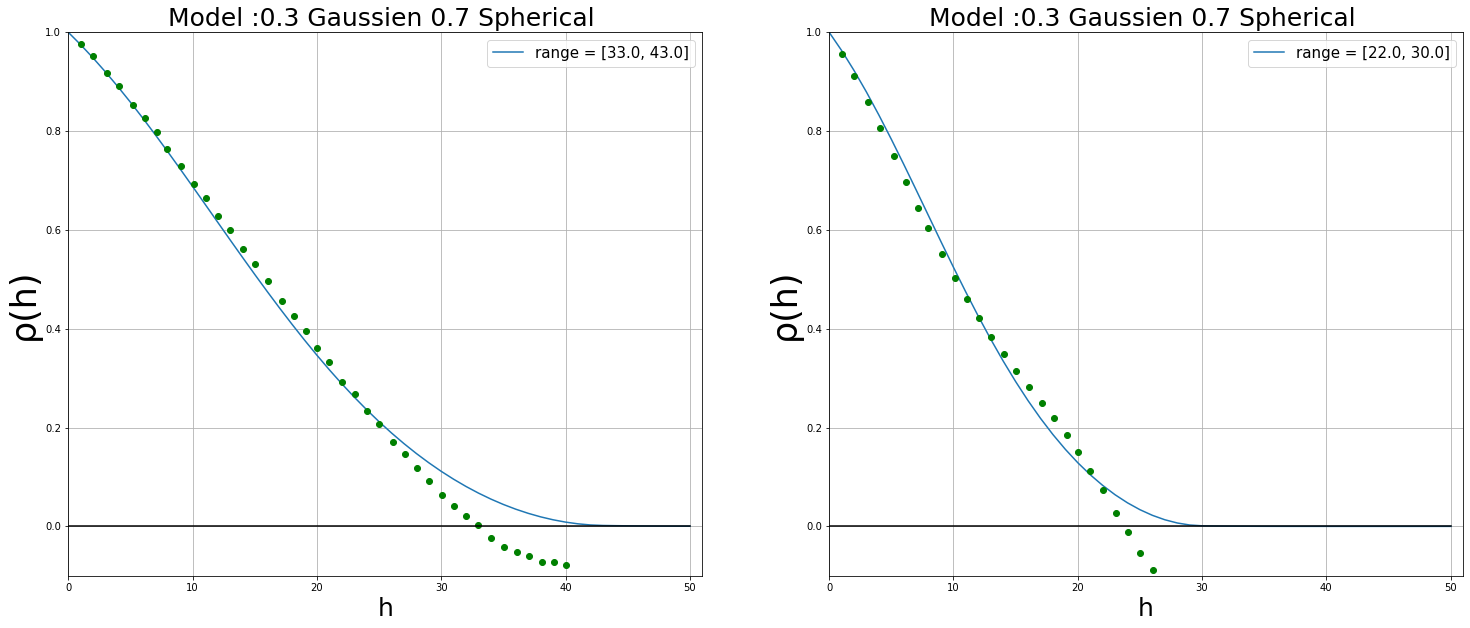

In [473]:
varg_type = 2  # See Correlogram Functions
Model = "Model8"


a_min_mesh = np.linspace(25,35,6)
a_max_mesh = np.linspace(35,45,6)
a_max = [a_max_gauss, a_max_spher]
a_min = [a_min_gauss, a_min_spher]
cc = [b,c]
vtype = [3,1]

k = 0
fig, axes = plt.subplots(1, 2, figsize=(25, 10))

MODEL = ["Spherical","Exponentiel","Gaussien"]
for Dir in Directions:
    
    print(a_max,a_min)

    for h in range(0, LENGTH + 1):
        cy[h],cc,vtype = C_Y_alternate(np.matrix(h), np.matrix(h), varg_type,
                                       a_max,a_min,
                                       cc, vtype, nstruct = 2)
        H[h] = h
    MM_vargs = [ None,cy,None ]

    for i in range(1, 2):
        if Dir == "Major" : 
            LABEL =  "range = {}".format(a_max)
        else :
            LABEL =  "range = {}".format(a_min)
        axes[k].plot(H, MM_vargs[i], label=LABEL)
        if (i + 1) < 3:


            var = locals()["varcalcfl_{}".format(i + 1)]
            axes[k].plot(
                var["Lag Distance"][
                    var["Variogram Index"] == (varg_type - 1)
                ],
                Sill_vals[i]
                - var["Variogram Value"][
                    var["Variogram Index"] == (varg_type - 1)
                ],
                "ro",
                color=colors[i]
                )
    
    TITLE = "Model :"
    for i in range(len(cc)) :
        TITLE += f"{cc[i]} {MODEL[vtype[i]-1]} "
        
    axes[k].plot(H, ones, color="Black")
    axes[k].grid()
    axes[k].set_xlim(0, LENGTH + 1)
    axes[k].set_ylim(-0.1, 1)
    axes[k].set_ylabel("\u03C1(h)", size=35)
    axes[k].set_xlabel("h", size=25)
    axes[k].set_title(
        TITLE,
        size=25,
    )
    axes[k].legend(loc="best", prop={"size": 15})
    #plt.savefig("MM1_MM2_var_{}".format(Dir), bbox_inches="tight", dpi=300)
    varg_type = varg_type + 1
    k +=1
    
    
    fileout =  "C:/Users/Alexandre/Desktop/Cours/Stage/\collocatedcokriging/\Correlogram_test/"+Model+".png"
    #plt.savefig(fileout, bbox_inches="tight")
    #axes[k].set_title(
        #"MMI  Correlogram Comparison {} Direction".format(Dir),
       # size=25)

In [80]:
var[var["Variogram Index"] == 1.0]

,Variogram Index,Lag Distance,Number of Pairs,Variogram Value,Variogram Number,Calculation Azimuth,Calculation Dip,Variogram Type,Variogram Tail Index,Variogram Head Index
0,1.0,0.00000,0.0,-999.00000,1.0,90.0,0.0,1.0,1.0,1.0
1,1.0,1.00000,9900.0,0.02450,1.0,90.0,0.0,1.0,1.0,1.0
2,1.0,2.00000,9800.0,0.04877,1.0,90.0,0.0,1.0,1.0,1.0
3,1.0,3.10782,28906.0,0.08298,1.0,90.0,0.0,1.0,1.0,1.0
4,1.0,4.08179,28608.0,0.10811,1.0,90.0,0.0,1.0,1.0,1.0
5,1.0,5.19251,46930.0,0.14639,1.0,90.0,0.0,1.0,1.0,1.0
6,1.0,6.16194,46436.0,0.17376,1.0,90.0,0.0,1.0,1.0,1.0
7,1.0,7.13962,45942.0,0.20266,1.0,90.0,0.0,1.0,1.0,1.0
8,1.0,7.97860,63490.0,0.23573,1.0,90.0,0.0,1.0,1.0,1.0
9,1.0,9.06674,80456.0,0.27131,1.0,90.0,0.0,1.0,1.0,1.0


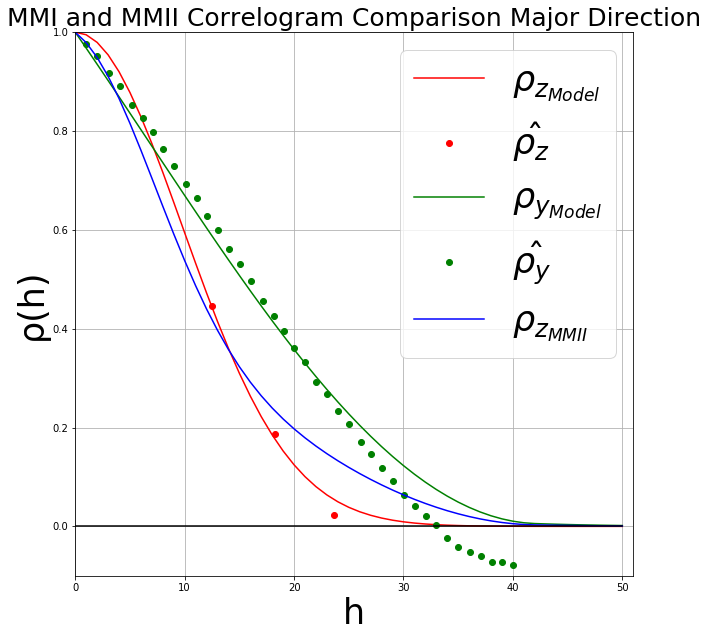

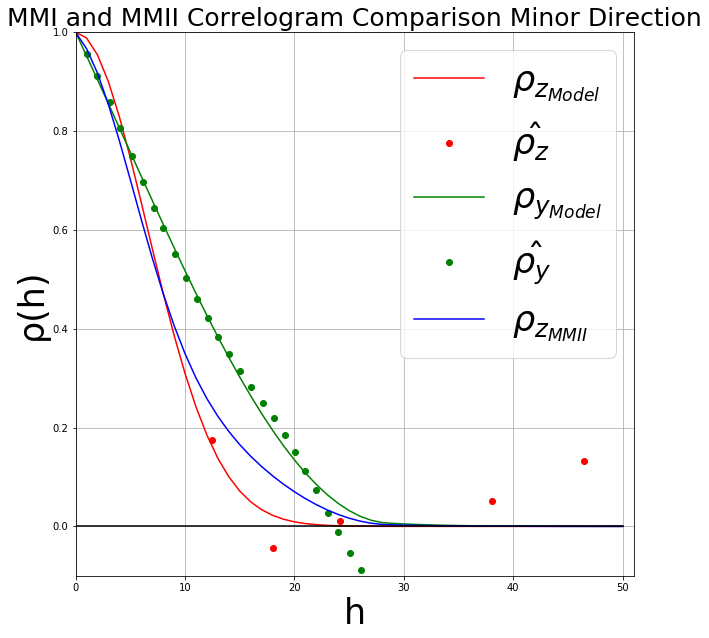

In [16]:
varg_type = 2  # See Correlogram Functions
for Dir in Directions:
    for h in range(0, 51):
        cy[h] = C_Y(np.matrix(h), np.matrix(h), varg_type)
        cz_True[h] = C_Z(np.matrix(h), np.matrix(h), varg_type)
        cz[h] = C_Z_MM2(np.matrix(h), np.matrix(h), varg_type, corr)
        cr[h] = C_r(np.matrix(h), np.matrix(h), varg_type)
        H[h] = h
    MM_vargs = [cz_True, cy, cz]
    fig, axes = plt.subplots(1, 1, figsize=(10, 10))
    for i in range(0, 3):
        axes.plot(H, MM_vargs[i], color=colors[i], label=labels_MM[i])
        if (i + 1) < 3:
            var = locals()["varcalcfl_{}".format(i + 1)]
            axes.plot(
                var["Lag Distance"][
                    var["Variogram Index"] == (varg_type - 1)
                ],
                Sill_vals[i]
                - var["Variogram Value"][
                    var["Variogram Index"] == (varg_type - 1)
                ],
                "ro",
                color=colors[i],
                label=labels_1[i],
            )

    axes.plot(H, ones, color="Black")
    axes.grid()
    plt.xlim(0, 51)
    plt.ylim(-0.1, 1)
    plt.ylabel("\u03C1(h)", size=35)
    plt.xlabel("h", size=35)
    plt.title(
        "MMI and MMII Correlogram Comparison {} Direction".format(Dir),
        size=25,
    )
    axes.legend(loc="best", prop={"size": 35})
    plt.savefig("MM1_MM2_var_{}".format(Dir), bbox_inches="tight", dpi=300)
    varg_type = varg_type + 1

## Cross Correlogram

In [17]:
def C_ZY(h1, h2, k, corr):
    C = []
    nstruct = 1
    vtype = [1]
    a_max = [45]
    a_min = [30]
    Azimuth = 90
    cc = [corr]
    c = 0
    for i in range(nstruct):
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                ).sum(axis=1)
            )
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1) * cc[i]
    return c

## LMC

The new variogram that will be used for full cokriging, these variograms will be slightly differnt the variograms modelled above. For LMC variograms the sill should be the variance of the variable for the primary and secondary variables. The correlations is the sill of the cross-correlogram

### Primary

In [18]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_Z_LMC(h1, h2, k):
    C = []
    nstruct = 2
    vtype = [1, 1]
    a_max = [33, 40]
    a_min = [15, 30]
    Azimuth = 90
    cc = [0.85, 0.15]
    c = 0
    for i in range(nstruct):
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                ).sum(axis=1)
            )
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1) * cc[i]
    return c

### Secondary

In [19]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_Y_LMC(h1, h2, k):
    C = []
    nstruct = 2
    vtype = [1, 1]
    a_max = [33, 40]
    a_min = [15, 30]
    Azimuth = 90
    cc = [0.25, 0.75]
    c = 0
    for i in range(nstruct):
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                ).sum(axis=1)
            )
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1) * cc[i]
    return c

### Cross

In [20]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# Corr = correlation between primary and secondary data
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_ZY_LMC(h1, h2, k, corr):
    C = []
    nstruct = 2
    vtype = [1, 1]
    a_max = [33, 40]
    a_min = [15, 30]
    Azimuth = 90
    cc = [corr * 0.6, corr * 0.4]
    c = 0
    for i in range(nstruct):
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                ).sum(axis=1)
            )
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1) * cc[i]
    return c

In [21]:
s_1 = np.array([[0.0001, 0], [0, 0.0001]])
s_2 = np.array([[0.85, corr * 0.6], [corr * 0.6, 0.25]])
s_3 = np.array([[0.15, corr * 0.4], [corr * 0.4, 0.75]])

print(np.linalg.det(s_1))
print(np.linalg.det(s_2))
print(np.linalg.det(s_3))
print(s_1 + s_2 + s_3)

1.0000000000000018e-08
0.02601118558622157
0.029616082482765132
[[1.   0.72]
 [0.72 1.  ]]


### Plot LMC

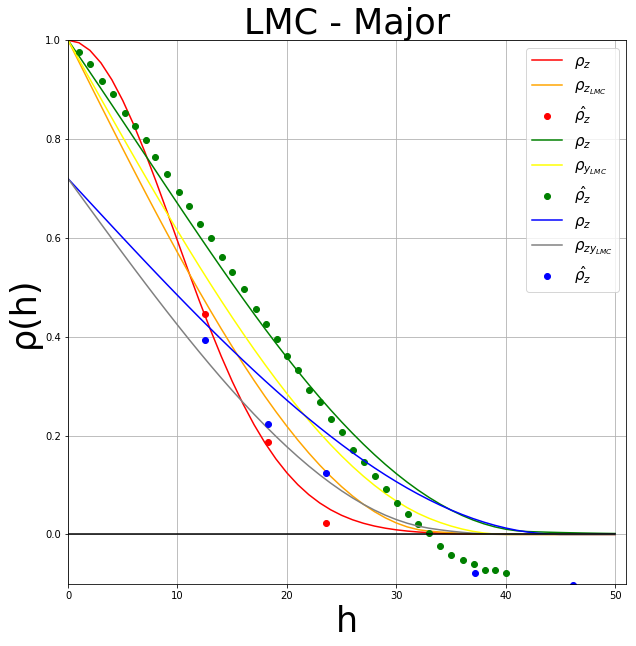

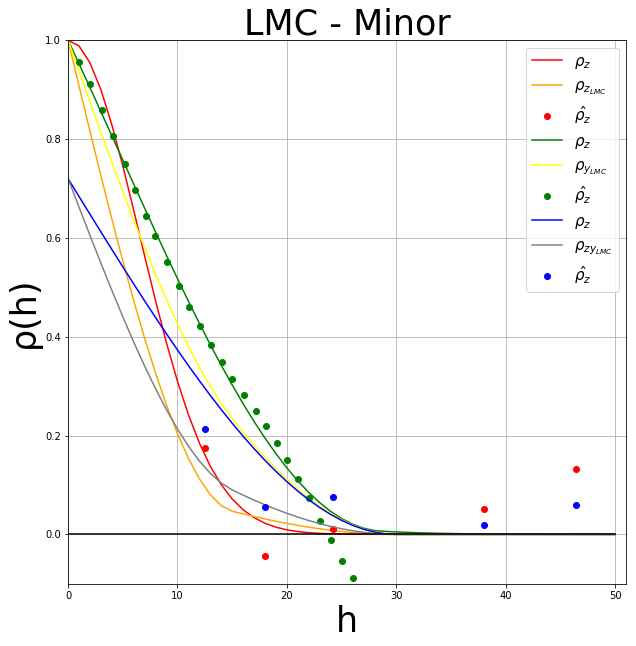

In [22]:
varg_type = 2  # See Correlogram Functions
for Dir in Directions:
    for h in range(0, 51):
        cy[h] = C_Y(np.matrix(h), np.matrix(h), varg_type)
        cz_True[h] = C_Z(np.matrix(h), np.matrix(h), varg_type)
        czy[h] = C_ZY(np.matrix(h), np.matrix(h), varg_type, corr)
        cy_LMC[h] = C_Y_LMC(np.matrix(h), np.matrix(h), varg_type)
        cz_LMC[h] = C_Z_LMC(np.matrix(h), np.matrix(h), varg_type)
        czy_LMC[h] = C_ZY_LMC(np.matrix(h), np.matrix(h), varg_type, corr)
    Vargs = [cz_True, cy, czy]
    LMCS = [cz_LMC, cy_LMC, czy_LMC]
    fig, axes = plt.subplots(1, 1, figsize=(10, 10))
    for i in range(0, 3):
        var = locals()["varcalcfl_{}".format(i + 1)]
        axes.plot(H, Vargs[i], color=colors[i], label=labels_2[0])
        axes.plot(H, LMCS[i], color=colors_lmc[i], label=labels_lmc[i])
        axes.plot(
            var["Lag Distance"][var["Variogram Index"] == (varg_type - 1)],
            Sill_vals[i]
            - var["Variogram Value"][
                var["Variogram Index"] == (varg_type - 1)
            ],
            "ro",
            color=colors[i],
            label=labels_1[0],
        )

    axes.plot(H, ones, color="Black")
    axes.grid()
    plt.xlim(0, 51)
    plt.ylim(-0.1, 1)
    plt.ylabel("\u03C1(h)", size=35)
    plt.xlabel("h", size=35)
    plt.title("LMC - {}".format(Dir), size=35)
    axes.legend(loc="best", prop={"size": 15})
    # plt.savefig('../0-Figures/MM1_MM2_var_{}'.format(Dir))
    varg_type = varg_type + 1

# Kriging

## Data Statistics

In [23]:
Mean_Z = np.average(datafl["Primary"])
STD_Z = 1.0
print(Mean_Z)
print(STD_Z)

-0.42471875000000003
1.0


In [24]:
Mean_Y = np.average(datafl["Secondary"])
STD_Y = 1.0
print(Mean_Y)
print(STD_Y)

-0.19742499999999996
1.0


In [25]:
corr = np.corrcoef(datafl["Primary"], datafl["Secondary"])[0, 1]
print(corr)

0.7197391780935076


## Create a KDTree to Quickly Get Nearest Points

In [26]:
from sklearn.neighbors import KDTree

In [27]:
datafl_XY = datafl[["X", "Y"]].values
tree = KDTree(datafl_XY)

In [28]:
Pred_grid_xy = np.matrix([x, y]).T

In [29]:
# Primary Data Search for Kriging
k = 60  # number of data to use
X_Y = np.zeros((len(x), k, 2))
X_Y_Star = np.zeros((len(x), k, 2))
closematrix_Primary = np.zeros((len(x), k))
closematrix_Secondary = np.zeros((len(x), k))
neardistmatrix = np.zeros((len(x), k))
for i in range(0, len(x)):
    nearest_dist, nearest_ind = tree.query(Pred_grid_xy[i : i + 1, :], k=k)
    a = nearest_ind.ravel()
    group = datafl.iloc[a, :]
    closematrix_Primary[i, :] = group["Primary"]
    closematrix_Secondary[i, :] = group["Secondary"]
    neardistmatrix[i, :] = nearest_dist
    X_Y[i, :, :] = group[["X", "Y"]]

In [30]:
datafl_XY_2nd = datafl_sec[["X", "Y"]].values
tree_2nd = KDTree(datafl_XY_2nd)

In [31]:
# Secondary Data Search for CoKriging
k = k  # number of neighbours
X_Y_2nd = np.zeros((len(x), k, 2))
closematrix_Secondary_2nd = np.zeros((len(x), k))
for i in range(0, len(x)):
    nearest_dist, nearest_ind = tree_2nd.query(
        Pred_grid_xy[i : i + 1, :], k=k
    )
    a = nearest_ind.ravel()
    group = datafl_sec.iloc[a, :]
    closematrix_Secondary_2nd[i, :] = group["Secondary"]
    X_Y_2nd[i, :, :] = group[["X", "Y"]]

## Simple Kriging

In [32]:
est_SK = np.zeros(shape=(len(x)))
for z in tqdm(range(0, len(x))):
    Kriging_Matrix = np.zeros(shape=((k, k)))
    # h = distance_matrix(X_Y[z,:,:].tolist(),X_Y[z,:,:].tolist())
    # C_ZZ
    Kriging_Matrix = C_Z(X_Y[z, :, :], X_Y[z, :, :], 0)
    # Set up Right Hand Side
    # print(Kriging_Matrix.reshape(((k)),((k))))
    r = np.zeros(shape=(k))
    k_weights = r
    # RHS #C_z*
    r = C_Z(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1)
    Kriging_Matrix.reshape(((k)), ((k)))
    # Calculate Kriging Weights
    try:
        k_weights = np.dot(np.linalg.inv(Kriging_Matrix), r)
    except:
        s_m = s_m + 1
        sm_idx.append(z)
        k_weights = np.dot(scipy.linalg.pinv(Kriging_Matrix), r)
    # Start Est at zero
    est_SK[z] = 0
    # add in mean_z
    est_SK[z] = est_SK[z] + Mean_Z
    for i in range(0, k):
        # add in Z_i
        est_SK[z] = est_SK[z] + k_weights[i] * (
            closematrix_Primary[z, i] - Mean_Z
        )

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:15<00:00, 657.58it/s]


## Full Cokriging

In [33]:
cz = np.zeros(shape=(k, k))
czy = np.zeros(shape=(k, k))
czy_2 = np.zeros(shape=(k, k))
cy = np.zeros(shape=(k, k))
s_m = 0
sm_idx = []
est_Full_CCK = np.zeros(shape=(len(x)))
for z in tqdm(range(0, len(x))):
    Kriging_Matrix = np.zeros(shape=((k * 2), (k * 2)))
    # C_ZZ
    cz = C_Z_LMC(X_Y[z, :, :], X_Y[z, :, :], 0)
    # C_ZY
    czy = C_ZY_LMC(X_Y[z, :, :], X_Y_2nd[z, :, :], 0, corr)
    czy_2 = C_ZY_LMC(X_Y_2nd[z, :, :], X_Y[z, :, :], 0, corr)
    # C_YY
    cy = C_Y_LMC(X_Y_2nd[z, :, :], X_Y_2nd[z, :, :], 0)
    Kriging_Matrix = np.vstack(
        (np.hstack((cz, czy)), np.hstack((czy.T, cy)))
    )
    # print(Kriging_Matrix)
    # Set up Right Hand Sides
    r = np.zeros(shape=(k * 2))
    k_weights = np.zeros(shape=(k * 2))
    # RHS #C_z*
    r[0:k] = C_Z_LMC(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1)
    # RHS #C_zy*
    r[k : k * 2] = C_ZY_LMC(
        X_Y_2nd[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1, corr
    )
    # Calculate Kriging Weights
    try:
        k_weights = np.dot(np.linalg.inv(Kriging_Matrix), r)
    except:
        s_m = s_m + 1
        sm_idx.append(z)
        k_weights = np.dot(scipy.linalg.pinv(Kriging_Matrix), r)
    # Start Est at zero
    est_Full_CCK[z] = 0
    # add in mean_z
    est_Full_CCK[z] = est_Full_CCK[z] + Mean_Z
    for i in range(0, k):
        # add in Z_i
        est_Full_CCK[z] = (
            est_Full_CCK[z]
            + k_weights[i] * (closematrix_Primary[z, i] - Mean_Z) / STD_Z
        )
        # add in Y_i
        est_Full_CCK[z] = (
            est_Full_CCK[z]
            + k_weights[i + k]
            * (closematrix_Secondary_2nd[z, i] - Mean_Y)
            / STD_Y
        )
print("There where {} Singular Matrices".format(s_m))

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:11<00:00, 138.99it/s]


There where 0 Singular Matrices


## Simple Collocated Cokriging - MM1

In [34]:
est_MM1 = np.zeros(shape=(len(x)))
for z in tqdm(range(0, len(x))):
    Kriging_Matrix = np.zeros(shape=((k + 1), (k + 1)))
    # C_ZZ
    Kriging_Matrix[0:k, 0:k] = C_Z(X_Y[z, :, :], X_Y[z, :, :], 0)
    # Set up Right Hand Side
    # print(Kriging_Matrix.reshape(((2*k)+1),((2*k)+1)))
    r = np.zeros(shape=(k + 1))
    k_weights = np.zeros(shape=(k))
    # RHS #C_z*
    r[0:k] = C_Z(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1)
    # RHS corr
    r[k] = corr
    # c_zy
    Kriging_Matrix[k, 0 : k + 1] = r * corr
    Kriging_Matrix[0 : k + 1, k] = r * corr
    Kriging_Matrix[k, k] = 1
    # Calculate Kriging Weights
    try:
        k_weights = np.dot(np.linalg.inv(Kriging_Matrix), r)
    except:
        s_m = s_m + 1
        sm_idx.append(z)
        k_weights = np.dot(scipy.linalg.pinv(Kriging_Matrix), r)
    # Start Est at zero
    est_MM1[z] = 0
    # add in mean_z
    est_MM1[z] = est_MM1[z] + Mean_Z
    # add in the Y_0
    est_MM1[z] = (
        est_MM1[z]
        + k_weights[k] * (datafl_sec["Secondary"][z] - Mean_Y) / STD_Y
    )
    for i in range(0, k):
        # add in Z_i
        est_MM1[z] = (
            est_MM1[z]
            + k_weights[i] * (closematrix_Primary[z, i] - Mean_Z) / STD_Z
        )


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 538.70it/s]


## Simple Collocated Cokriging - MM2

In [35]:
est_MM2 = np.zeros(shape=(len(x)))
s_m = 0
sm_idx = []
for z in tqdm(range(0, len(x))):
    Kriging_Matrix = np.zeros(shape=((k + 1), (k + 1)))
    # C_ZZ
    Kriging_Matrix[0:k, 0:k] = C_Z_MM2(X_Y[z, :, :], X_Y[z, :, :], 0, corr)
    # Set up Right Hand Side
    # print(Kriging_Matrix.reshape(((2*k)+1),((2*k)+1)))
    r = np.zeros(shape=(k + 1))
    k_weights = np.zeros(shape=(k))
    # RHS #C_z*
    r[0:k] = C_Z_MM2(
        X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1, corr
    )
    # RHS corr
    r[k] = corr
    # c_zy
    Kriging_Matrix[k, 0:k] = (
        C_Y(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1) * corr
    )
    Kriging_Matrix[0:k, k] = (
        C_Y(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1) * corr
    )
    Kriging_Matrix[k, k] = 1
    # Calculate Kriging Weights
    try:
        k_weights = np.dot(np.linalg.inv(Kriging_Matrix), r)
    except:
        s_m = s_m + 1
        sm_idx.append(z)
        k_weights = np.dot(scipy.linalg.pinv(Kriging_Matrix), r)
    # Start Est at zero
    est_MM2[z] = 0
    # add in mean_z
    est_MM2[z] = est_MM2[z] + Mean_Z
    # add in the Y_0
    est_MM2[z] = (
        est_MM2[z]
        + k_weights[k] * (datafl_sec["Secondary"][z] - Mean_Y) / STD_Y
    )
    for i in range(0, k):
        # add in Z_i
        est_MM2[z] = (
            est_MM2[z]
            + k_weights[i] * (closematrix_Primary[z, i] - Mean_Z) / STD_Z
        )
print("There where {} Singular Matrices".format(s_m))

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:42<00:00, 235.73it/s]


There where 0 Singular Matrices


## Intrinsic Collocated Cokriging - MM1

In [36]:
s_m = 0
sm_idx = []
cz = np.zeros(shape=(k, k))
czy = np.zeros(shape=(k, k))
cy = np.zeros(shape=(k, k))
est_icck_MM1 = np.zeros(shape=(len(x)))
for z in tqdm(range(0, len(x))):
    Kriging_Matrix = np.zeros(shape=((k * 2 + 1), (k * 2 + 1)))
    # C_ZZ
    cz = C_Z(X_Y[z, :, :], X_Y[z, :, :], 0)
    # C_ZY
    czy = C_Z(X_Y[z, :, :], X_Y[z, :, :], 0) * corr
    # C_YY
    cy = C_Z(X_Y[z, :, :], X_Y[z, :, :], 0)
    # Set up Right Hand Side
    Kriging_Matrix[0 : k * 2, 0 : k * 2] = np.vstack(
        (np.hstack((cz, czy)), np.hstack((czy.T, cy)))
    )
    # print(Kriging_Matrix.reshape(((2*k)+1),((2*k)+1)))
    r = np.zeros(shape=(k * 2) + 1)
    k_weights = r
    # RHS #C_z*
    r[0:k] = C_Z(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1)
    # RHS #C_yz*
    r[k : k * 2] = (
        C_Z(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1) * corr
    )
    # RHS corr
    r[k * 2] = corr
    # c_zy
    Kriging_Matrix[k * 2, 0:k] = (
        C_Z(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1) * corr
    )
    Kriging_Matrix[0:k, k * 2] = (
        C_Z(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1) * corr
    )
    # c_z
    Kriging_Matrix[k * 2, k : k * 2] = C_Z(
        X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1
    )
    Kriging_Matrix[k : k * 2, k * 2] = C_Z(
        X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1
    )
    Kriging_Matrix[k * 2, k * 2] = 1
    # Calculate Kriging Weights
    try:
        k_weights = np.dot(np.linalg.inv(Kriging_Matrix), r)
    except:
        s_m = s_m + 1
        sm_idx.append(z)
        k_weights = np.dot(scipy.linalg.pinv(Kriging_Matrix), r)
    # Start Est at zero
    est_icck_MM1[z] = 0
    # add in mean_z
    est_icck_MM1[z] = est_icck_MM1[z] + Mean_Z
    # add in the Y_0
    est_icck_MM1[z] = (
        est_icck_MM1[z]
        + k_weights[k * 2] * (datafl_sec["Secondary"][z] - Mean_Y) / STD_Y
    )
    for i in range(0, k):
        # add in Z_i
        est_icck_MM1[z] = (
            est_icck_MM1[z]
            + k_weights[i] * (closematrix_Primary[z, i] - Mean_Z) / STD_Z
        )
        # add in Y_i
        est_icck_MM1[z] = (
            est_icck_MM1[z]
            + k_weights[i + k]
            * (closematrix_Secondary[z, i] - Mean_Y)
            / STD_Y
        )
print("There where {} Singular Matrices".format(s_m))

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:50<00:00, 197.97it/s]


There where 0 Singular Matrices


## Intrinsic Collocated Cokriging - MM2

In [37]:
s_m = 0
sm_idx = []
cz = np.zeros(shape=(k, k))
czy = np.zeros(shape=(k, k))
cy = np.zeros(shape=(k, k))
est_icck_MM2 = np.zeros(shape=(len(x)))
for z in tqdm(range(0, len(x))):
    Kriging_Matrix = np.zeros(shape=((k * 2 + 1), (k * 2 + 1)))
    # C_ZZ
    # 1
    cz = C_Z_MM2(X_Y[z, :, :], X_Y[z, :, :], 0, corr)
    # C_ZY
    # 2,#3
    czy = corr * C_Y(X_Y[z, :, :], X_Y[z, :, :], 0)
    # C_YY
    # 4
    cy = C_Y(X_Y[z, :, :], X_Y[z, :, :], 0)
    # Set up Right Hand Side
    # print(Kriging_Matrix.reshape(((2*k)+1),((2*k)+1)))
    Kriging_Matrix[0 : k * 2, 0 : k * 2] = np.vstack(
        (np.hstack((cz, czy)), np.hstack((czy.T, cy)))
    )
    r = np.zeros(shape=(k * 2) + 1)
    k_weights = r
    # RHS #C_z*
    # 5
    r[0:k] = C_Z_MM2(
        X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1, corr
    )
    # RHS #C_yz*
    # 6
    r[k : k * 2] = (
        C_Y(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1) * corr
    )
    # RHS corr
    # 7
    r[k * 2] = corr
    # c_zy
    # 8
    Kriging_Matrix[k * 2, 0:k] = (
        C_Y(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1) * corr
    )
    Kriging_Matrix[0:k, k * 2] = (
        C_Y(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1) * corr
    )
    # c_y
    # 9
    Kriging_Matrix[k * 2, k : k * 2] = C_Y(
        X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1
    )
    Kriging_Matrix[k : k * 2, k * 2] = C_Y(
        X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1
    )
    Kriging_Matrix[k * 2, k * 2] = 1
    # Kriging_Matrix.reshape(((2*k)+1),((2*k)+1))
    # Calculate Kriging Weights
    try:
        k_weights = np.dot(np.linalg.inv(Kriging_Matrix), r)
    except:
        s_m = s_m + 1
        sm_idx.append(z)
        k_weights = np.dot(scipy.linalg.pinv(Kriging_Matrix), r)
    # Start Est at zero
    est_icck_MM2[z] = 0
    # add in mean_z
    est_icck_MM2[z] = est_icck_MM2[z] + Mean_Z
    # add in the Y_0
    est_icck_MM2[z] = (
        est_icck_MM2[z]
        + k_weights[k * 2] * (datafl_sec["Secondary"][z] - Mean_Y) / STD_Y
    )
    for i in range(0, k):
        # add in Z_i
        est_icck_MM2[z] = (
            est_icck_MM2[z]
            + k_weights[i] * (closematrix_Primary[z, i] - Mean_Z) / STD_Z
        )
        # add in Y_i
        est_icck_MM2[z] = (
            est_icck_MM2[z]
            + k_weights[i + k]
            * (closematrix_Secondary[z, i] - Mean_Y)
            / STD_Y
        )
print("There where {} Singular Matrices".format(s_m))

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:18<00:00, 126.80it/s]


There where 0 Singular Matrices


## Results

In [38]:
# Setup Dictionary of Results
ktypes = ["SK", "SCK", "SCCK_MMI", "SCCK_MMII", "ICCK_MMI", "ICCK_MMII"]
k_est = [
    est_SK,
    est_Full_CCK,
    est_MM1,
    est_MM2,
    est_icck_MM1,
    est_icck_MM2,
]
ktypes_vals_dict = {}
j = 0
for i in ktypes:
    ktypes_vals_dict[i] = {
        "Estimate": k_est[j],
        "RMSE": np.sqrt(mean_squared_error(k_est[j], truth["Primary"])),
        "Mean": np.mean(k_est[j]),
        "Variance": np.var(k_est[j]),
    }
    j = j + 1

### Pixelplt

In [39]:
# Setup Subplot Function
def plot_axe(figsize):
    # Set up Plotting Grid
    axes = []
    fig = plt.figure(constrained_layout=True, figsize=figsize)
    gs = gridspec.GridSpec(3, 4, figure=fig)
    gs.update(wspace=0.01, hspace=0.01)
    k = 0
    for i in range(0, 3):
        for j in range(1, 3):
            k = k + 1
            ax = locals()["ax{}".format(k)] = plt.subplot(
                gs[i, (j - 1) * 2 : j * 2]
            )
            axes.append(ax)
    return fig, gs, axes

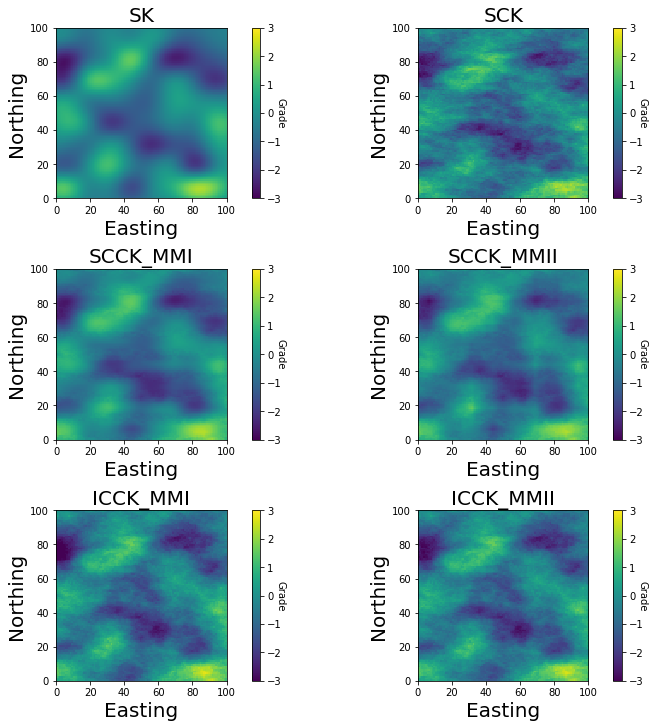

In [40]:
fig, gs, axes = plot_axe(figsize=(10, 10))
ax_i = 0
for i in ktypes:
    gridd["Estimate"] = ktypes_vals_dict[i]["Estimate"]
    gridded = np.reshape(
        gridd.sort_values(by=["Y", "X"], axis=0, ascending=True)[
            "Estimate"
        ].values,
        [100, 100],
        order="C",
    )
    ax = axes[ax_i]
    plt_1 = ax.imshow(
        gridded,
        origin="lower",
        extent=[XMIN, XMAX, YMIN, YMAX],
        aspect="equal",
        interpolation="none",
        vmin=SMIN,
        vmax=SMAX,
        cmap="viridis",
    )
    ax.set_title("{}".format(i), size=20)
    ax.set_xlabel("Easting", size=20)
    ax.set_ylabel("Northing", size=20)
    cbar = plt.colorbar(plt_1, ax=ax)
    cbar.set_label("Grade", rotation=270)
    ax_i = ax_i + 1
plt.show()
fig.savefig("estimates.png", bbox_inches="tight", dpi=300)

### Data Reproduction

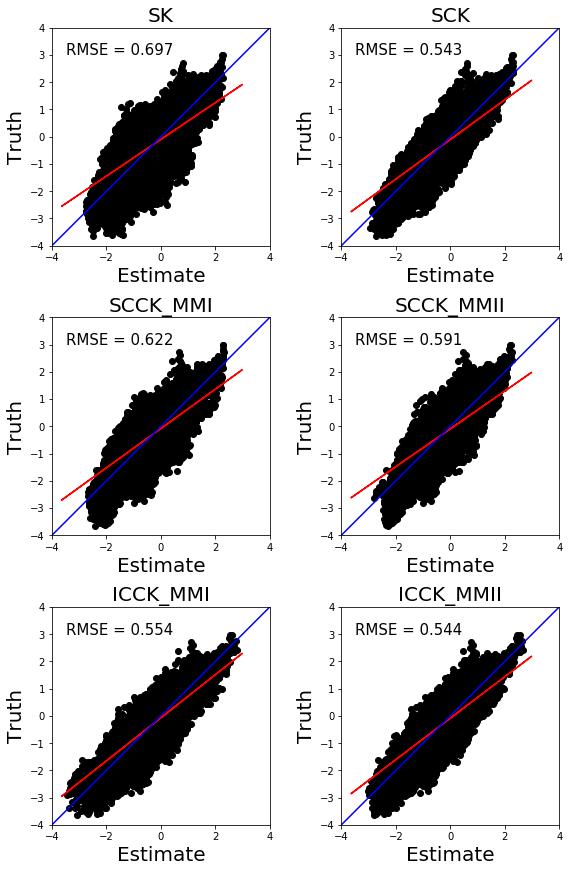

In [41]:
fig, gs, axes = plot_axe(figsize=(8, 12))
ax_i = 0
for i in ktypes:
    ax = axes[ax_i]
    ax.scatter(
        ktypes_vals_dict[i]["Estimate"], truth["Primary"], color="Black"
    )
    ax.plot(
        (truth["Primary"]),
        np.poly1d(
            np.polyfit(
                truth["Primary"], ktypes_vals_dict[i]["Estimate"], 1
            )
        )((truth["Primary"])),
        color="Red",
    )
    ax.set_title("{}".format(i), size=20)
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    x_45 = np.linspace(*ax.get_xlim())
    ax.plot(x_45, x_45, color="blue")
    ax.set_xlabel("Estimate", size=20)
    ax.set_ylabel("Truth", size=20)
    ax.set_aspect("equal", "box")
    ax.text(
        -3.5,
        3.0,
        "RMSE = {:.3f}".format(ktypes_vals_dict[i]["RMSE"]),
        size=15,
    )
    ax_i = ax_i + 1
plt.show()
fig.savefig("scatter_true.png", bbox_inches="tight", dpi=300)

# Annexe

In [78]:
def optimize_RMSE(a_max,a_min,b):
    c_dict = {}
    Direction = ["Major","Minor"]
    RMSE = []
    
    for k,range_ in enumerate([a_max,a_min]) :
        var = varcalcfl_2[varcalcfl_2["Variogram Value"] != -999] # drop les valeurs -999 
        
        variogram_lag = var["Lag Distance"][var["Variogram Index"] == float(k+1)] # 1.0 Major / 2.0 Minor
        variogram_value =1 - var["Variogram Value"][var["Variogram Index"] == float(k+1)]
        
        Dir = Direction[k] # Nécessaire pour le dictionnaire
        lag_value = variogram_lag / range_ # valeurs des lags / range
        
        c = [] # liste des covario
        for d,v in zip(lag_value,variogram_value) : # Zip avec variogram_value inutile
            
            c.append(b*(np.exp(-3 * np.square(d))))
        
        RMSE.append(mean_squared_error(variogram_value,c))
            
        c_dict[Dir] = {"RMSE" : RMSE,
                      "correlogram" : c,
                      "a_max" : a_max,
                      "a_min" : a_min,
                      "b" : b}
    return c_dict,sum(RMSE)

In [86]:
def optimize_RMSE_altenative(x):
    a_min = x[0]
    a_max = x[1]
    b = x[2]
    
    c_dict = {}
    Direction = ["Major","Minor"]
    RMSE = []
    
    for k,range_ in enumerate([a_max,a_min]) :
        var = varcalcfl_2[varcalcfl_2["Variogram Value"] != -999] # drop les valeurs -999 
        
        variogram_lag = var["Lag Distance"][var["Variogram Index"] == float(k+1)] # 1.0 Major / 2.0 Minor
        variogram_value =1 - var["Variogram Value"][var["Variogram Index"] == float(k+1)]
        
        Dir = Direction[k] # Nécessaire pour le dictionnaire
        lag_value = variogram_lag / range_ # valeurs des lags / range
        
        c = [] # liste des covario
        
        for d,v in zip(lag_value,variogram_value) : # Zip avec variogram_value inutile
            MODEL = b*(np.exp(-3 * np.square(d)))
            c.append(MODEL)
        
        RMSE.append(mean_squared_error(variogram_value,c))
        
        c_dict[Dir] = {"RMSE" : RMSE,
                      "correlogram" : c,
                      "a_max" : a_max,
                      "a_min" : a_min,
                      "b" : b}
    
    return sum(RMSE)

In [142]:
def optimize_RMSE_altenative2(x):
    a_min = x[0]
    a_max = x[1]
    b = x[2]
    Direction = ["Major","Minor"]
    RMSE = []
    for k,range_ in enumerate([a_max,a_min]) :
        var = varcalcfl_2[varcalcfl_2["Variogram Value"] != -999] # drop les valeurs -999 
        
        variogram_lag = var["Lag Distance"][var["Variogram Index"] == float(k+1)] # 1.0 Major / 2.0 Minor
        variogram_value =1 - var["Variogram Value"][var["Variogram Index"] == float(k+1)]
        lag_value = variogram_lag / range_ # valeurs des lags / range
        
        c = [] # liste des covario
        
        for d in lag_value:
            
            MODEL = b*(np.exp(-3 * np.square(d)))
            c.append(MODEL)
        
        RMSE.append(mean_squared_error(variogram_value,c))

    return sum(RMSE)

In [122]:
def optimize_RMSE_altenative3(x):
    range_ = x[0]
    b = x[1]
    
    RMSE = []
    var = varcalcfl_1[varcalcfl_1["Variogram Value"] != -999] # drop les valeurs -999 

    variogram_lag = var["Lag Distance"][var["Variogram Index"] == float(2)] # 1.0 Major / 2.0 Minor
    variogram_value =1 - var["Variogram Value"][var["Variogram Index"] == float(2)]
    lag_value = variogram_lag / range_ # valeurs des lags / range
    c = [] # liste des covario

    for d in lag_value:

        MODEL = b*(np.exp(-3 * np.square(d))) # Gaussien 
        c.append(MODEL)
    RMSE.append(mean_squared_error(variogram_value,c))

    return sum(RMSE)

In [214]:
def optimize_RMSE_altenative4(x, args):
    range_ = x[0]
    b = x[1]
    print(range_ , b)
    
    RMSE = []
    var = args[args["Variogram Value"] != -999] # drop les valeurs -999 

    variogram_lag = var["Lag Distance"][var["Variogram Index"] == float(2)] # 1.0 Major / 2.0 Minor
    variogram_value =1 - var["Variogram Value"][var["Variogram Index"] == float(2)]
    lag_value = variogram_lag / range_ # valeurs des lags / range
    c = [] # liste des covario

    for d in lag_value:

        MODEL = b*(np.exp(-3 * np.square(d))) # Gaussien 
        c.append(MODEL)
    RMSE.append(np.sqrt(mean_squared_error(variogram_value,c)))
    print("RMSE :", RMSE)
    print("sum(RMSE) :", sum(RMSE), "\n")
    return sum(RMSE)